In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import gpytorch
import amort_bnn
import gp_datasets
import tqdm.auto as tqdm

torch.set_default_dtype(torch.float64)

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
gpdg = gp_datasets.GPDataGenerator()
num_tasks = 50

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


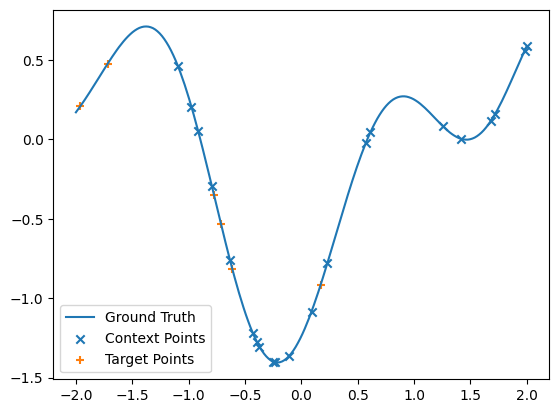

In [77]:
tasks = [gpdg.generate_task() for i in range(num_tasks)]
task = tasks[0]
plt.plot(task['x'], task['y'], label='Ground Truth')
plt.scatter(task['x_context'], task['y_context'], label='Context Points', marker='x')
plt.scatter(task['x_target'], task['y_target'], label='Target Points', marker='+')
plt.legend()
plt.show()